# Water Product Interoperability  

It's good combine imagery sources as it increases temporal adfsdf

Temporal 

### Current Water products  

Interoperability is explored across three derived water products from `Sentinel 1`, `Sentinel 2` and `Landsat 8`. The classification and initial data-exploration is conducted in separate notebooks listed below: 

   - `Sentinel 1`- [link]()    
   A thresholding algorthim takes advantage of linear class separability on vv and vh bands to classify water.  
     
     
   - `Landsat 8`- [link]()    
   The Water Observations From Space(WOFS) algorithm is applied to Landsat8 imagery. WOFS uses a decision tree on surface reflectance features.    
   
   
   - `Sentinel 2`- [link]()    
   The Water Observations From Space(WOFS) algorithm is applied to Sentinel 2 imagery. While the original WOFS algorithm was trained and calibrated on Landsat 7 imagery, relatively consistent results are expected from a re-application on Sentinel 2 imagery and are tolerated for the purpose of exploring interoperability.     
   
The outputs of these notebooks are temporarily saved into corressponding `netcdf` files. To properly run this notebook. Ensure that the notebooks listed above have been run.  


### Loading Water Products  

The following code lists the paths for three water products and loads them into the notebook.  

In [3]:
from calendar import month_name
import numpy as np
import xarray as xr
from pathlib import Path
from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook
from bokeh.core.properties import value
from bokeh.transform import dodge
from bokeh.models import Label
from bokeh.palettes import Accent6, Dark2, Category10
from bokeh.colors.named import darkgray

In [4]:
output_notebook()

Loading BokehJS ...

In [5]:
# Define dataset file paths
DATA_DIR = Path('output/netcdfs')
DATASETS = {
    'l8': DATA_DIR / 'landsat8_nbar' / 'water_classify.nc',
    's1': DATA_DIR / 'sentinel_1_gamma' / 'water_classify.nc',
    's2': DATA_DIR / 'sentinel_2_ab' / 'water_classify.nc'
}

In [6]:
# Load datasets
datasets = {name: xr.open_dataset(path) for name, path in DATASETS.items()}
print('Loaded datasets: {}'.format(', '.join(datasets.keys())))

Loaded datasets: l8, s1, s2


In [1]:
# paths = ["output/netcdfs/landsat8_nbar/water_classify.nc",
#          "output/netcdfs/sentinel_2_ab/water_classify.nc",
#          "output/netcdfs/sentinel_1_gamma/water_classify.nc"
#         ]

In [3]:
# s1 = xr.open_dataset(paths[2])
# s2 = xr.open_dataset(paths[1])
# ls8 = xr.open_dataset(paths[0])

Each xarray contains a variable called `wofs` that houses water classifications from the classifiers. Values in these xarray assume one of three values. `1`,`0` for water and not-water as well as `nan` values for areas occluded by cloud or are missing data.  

### Areas of Investigation and Measures of Interoperability

- **Availability**
- **Variability**
- **Visual Interpretability**


# Availability

In [4]:
# dataset_dicts = {"Sentinel 1" : s1.wofs,
#                  "Sentinel 2 nbart" : s2.wofs,
#                  "Landsat 8 nbar": ls8.wofs}

**Acquisition Count Per Month**

In [7]:
# Calculate frequencies per months. Months with no data are handled by combining with
# an empty `all_months` data array. 
coords={'month': range(1, 13)}
months_str = [m[:3] for m in list(month_name)[1:]]
frequencies = {}
for name, dataset in datasets.items():
    freq = dataset.time.groupby('time.month').count('time')
    all_months = xr.DataArray(data = [0]*12, coords=coords, dims=coords, name='time')
    frequencies[name] = freq.combine_first(all_months).assign_coords(month=months_str)

In [8]:
# Calculate the aggregated value for each month
aggregated = np.sum([freq.values for freq in frequencies.values()], axis=0)
aggregated

array([ 5,  8,  7,  8,  7,  6, 11,  9, 11,  9, 10, 11])

In [10]:
# Generate the bar chart on a new figure
data = {name: freq.values for name, freq in frequencies.items()}
data['months'] = months_str
data['aggregated'] = aggregated

# Calculate the max frequency to scale the Y-axis automatically
max_freq = max([freq.values.max() for freq in frequencies.values()] + [aggregated.max()])

p = figure(x_range=months_str,
           y_range=(0, max_freq),
           plot_width=800,
           plot_height=400,
           title="Monthly data points",
           toolbar_location=None,
           tools="")

# Calculate offsets and widths for the bars
inter_group = 0.4
width = (1 - inter_group / 2) / len(frequencies)
offset = (width + inter_group / 2 - 1) / 2

# Plot the aggregate bar
p.vbar(x=dodge('months', 0, range=p.x_range), 
       top='aggregated', 
       width=(1 - inter_group + width / 2), 
       source=data,
       color='#000000', 
       legend=value('aggregated'), 
       fill_alpha=0, 
       line_color='lightgray', 
       line_width=2.0)

# Plot the raw data bars, one per dataset
for count, name in enumerate(frequencies.keys()):
    p.vbar(x=dodge('months', count*width+offset, range=p.x_range), 
           top=name, 
           width=width-0.1, 
           source=data,
           color=Category10[10][count],
           legend=value(name), 
           fill_alpha=.4)
    
p.x_range.range_padding = 0.1
p.xgrid.grid_line_color = None
p.legend.location = "top_left"
p.legend.orientation = "horizontal"
show(p)

In [7]:
from typing import Dict
from functools import reduce
import matplotlib.pyplot as plt  
import numpy as np  

def plot(dataset_dicts: Dict[str,xr.DataArray]):
    fig, axs = plt.subplots(len(dataset_dicts) + 1, 1,
                            sharey=True,
                            tight_layout = True,
                            figsize = (15,(len(dataset_dicts) + 1)*2))

    for i, name in enumerate(dataset_dicts):
        _ = axs[i].hist(dataset_dicts[name].time.values, bins = 12, alpha = 0.5,)
        axs[i].set_title(name)


    axs[len(dataset_dicts)].hist(reduce(np.append,map(lambda prod: prod.time.values,list(dataset_dicts.values()))),bins = 12,alpha = 0.5,color = "red")
    axs[len(dataset_dicts)].set_title("Combined")


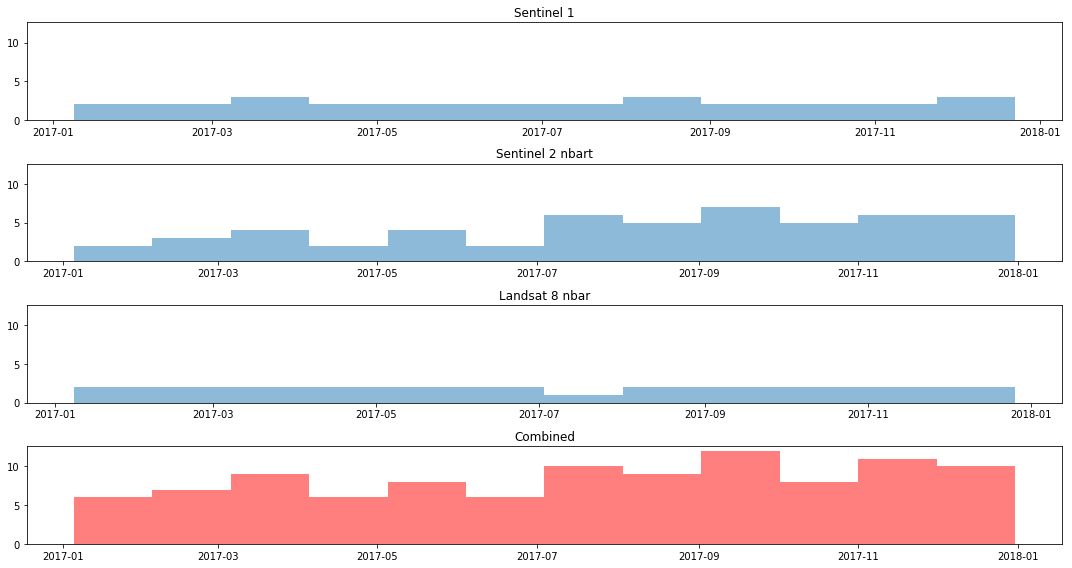

In [8]:
plot(dataset_dicts)

In [ ]:
# Calculate frequencies per months. Months with no data are handled by combining with
# an empty `all_months` data array. 
coords={'month': range(1, 13)}
months_str = [m[:3] for m in list(month_name)[1:]]
frequencies = {}
for name, dataset in datasets.items():
    freq = dataset.time.groupby('time.month').count('time')
    all_months = xr.DataArray(data = [0]*12, coords=coords, dims=coords, name='time')
    frequencies[name] = freq.combine_first(all_months).assign_coords(month=months_str)